Author: Alex Egg

This is my submission for the Machine Learning Scientist role at Amazon Development Centre (Scotland). I spent about 2 hours on it.

## Intro

My old professor at UCSD, Yoav Freund, is one of the original innovators behind Boosting methods. Accordingly, I thought I'd  give it a shot for this Amazon DC Scotland homework. 

First, I'll start simple w/ a regularized linear regression model, then I'll try a Gradient Boosted Regression.

### Tools

We will make extensive use of pandas and numpy for the initial data cleaning and processing. Then I will use the convenient scikit modules for training and evaluation metrics:

In [ ]:
import pandas as pd
import numpy as np
%pylab inline
import matplotlib.pyplot as plt

# Preprocess Data

For protyping I randomly sampled 10% the original dataset w/ this command:

In [ ]:
!cat data/pp-complete.csv  | awk 'BEGIN {srand()} !/^$/ { if (rand() <= .10) print $0}' > data/sample_10.csv

In [ ]:
!wc -l data/sample_10.csv

In [ ]:
headers=["ID", "Price Sale", "Date of Transfer", "Postcode", "Property Type", "Old/New", "Duration", "PAON", "SAON",
         "Street", "Locality", "Town/City", "District", "County", "PPD Category Type", "Record Status"]
raw = pd.read_csv("data/sample_10.csv", names=headers, parse_dates=["Date of Transfer"], index_col=0)

In [ ]:
print raw.shape
raw.head()

## Data preprocessing:

We're not going to do anything fancy here:

* Remove outliers
* Transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal
* Create Dummy variables for the categorical features

In [ ]:
data = raw.drop(raw[raw["Price Sale"]>2000000].index)
data = data.drop(raw[raw["Price Sale"]<15000].index)

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"A. price": data["Price Sale"], "B. log(price + 1)": np.log1p(data["Price Sale"])})
prices.hist()

In [ ]:
#per the instructions we are using these three features for training
feature_cols = ["Date of Transfer", "Property Type", "Duration", "Town/City"]
reduced = data[["Price Sale"] + feature_cols]
#log transform the target:
reduced["SalePrice"] = np.log1p(reduced["Price Sale"])
reduced["is_london"] = reduced["Town/City"].apply(lambda x: 1 if (x=="LONDON") else 0)
reduced = reduced[["SalePrice", "Date of Transfer", "Property Type", "Duration", "is_london"]]
reduced.head()

### Categorical Features
Since all the features are categorical, we will one-hot encode them as features for the training process:

In [ ]:
reduced = pd.get_dummies(reduced)
reduced.head(1)

# Training

Now, in preparation for training and testing, we can now split our dataset into a training set and a test set. We can either do this randomly or by an arbitrary date.

In [217]:
def test_train_split_on_date(data, d):
    feature_cols=['is_london', 'Property Type_D', 'Property Type_F',
        'Property Type_O', 'Property Type_S', 'Property Type_T',
        'Duration_F', 'Duration_L', 'Duration_U']
    pre = data[data["Date of Transfer"]< d]
    post = data[data["Date of Transfer"]>=d]
    x_train = pre[feature_cols]
    y_train = pre[["SalePrice"]]
    x_test = post[feature_cols]
    y_test = post[["SalePrice"]]
    
    return x_train.values, x_test.values, y_train.values.ravel(), y_test.values.ravel()

X_train, X_test, Y_train, Y_test = test_train_split_on_date(reduced, date(2015, 1, 1))
print X_train.shape
print X_test.shape

(1995984, 9)
(172499, 9)


In [218]:
# #test train split
from sklearn.model_selection import train_test_split
features = reduced[['is_london', 'Property Type_D', 'Property Type_F',
       'Property Type_O', 'Property Type_S', 'Property Type_T',
       'Duration_F', 'Duration_L', 'Duration_U']]
targets = reduced[["SalePrice"]]
X_train, X_test, Y_train, Y_test = train_test_split(features.values, targets.values.ravel(), test_size=0.25, random_state=4)
print X_train.shape
print X_test.shape

(1626362, 9)
(542121, 9)


# Models


## Ridge Regression

Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning pair

In [223]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [224]:
model_ridge = Ridge()

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [225]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

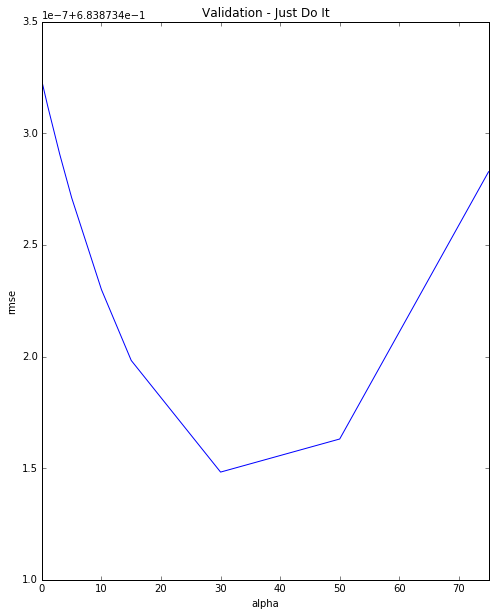

In [226]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

Note the U-ish shaped curve above. When alpha is too small the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha large) the model begins to overfit. A value of **`alpha = 30`** is about right based on the plot above.

In [227]:
cv_ridge.min()

0.68387354826031843

So for the Ridge regression we get a rmsle of about 0.68

## Lasso Regression

Let's try out the Lasso model. We will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha for us. For some reason the alphas in Lasso CV are really the inverse or the alphas in Ridge.

In [228]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, Y_train)

In [229]:
rmse_cv(model_lasso).mean()

0.68397386419753425

Lasso seems to preform the same, so we'll use it on the dataset. Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [230]:
coef = pd.Series(model_lasso.coef_, index = features.columns)

In [231]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 7 variables and eliminated the other 2 variables


Good job Lasso. One thing to note here however is that the features selected are not necessarily the "correct" ones - especially since there are a lot of collinear features in this dataset. One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.

We can also take a look directly at what the most important coefficients are:

In [232]:
imp_coef = pd.DataFrame(coef.sort_values())

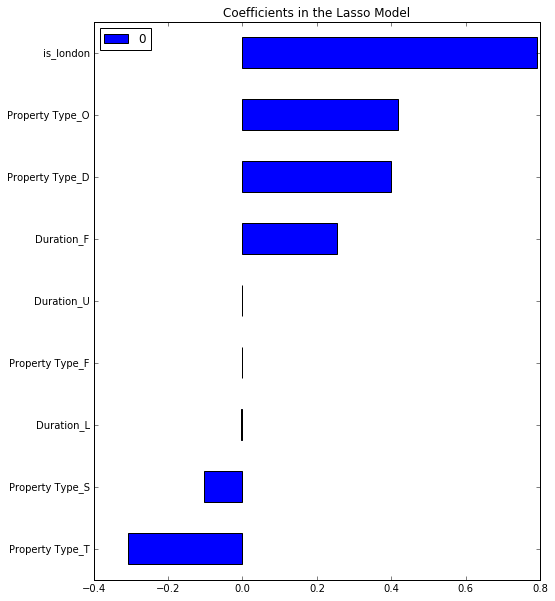

In [233]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

The most important positive feature is the London boolean-- whether or not this property is in London. This definitely makes sense. Then a few other location and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

Also note that unlike the feature importance you'd get from a random forest these are actual coefficients in your model - so you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret.


## Gradient Boosted Regressor

Let's add an xgboost model to our linear model to see if we can improve our score:

In [234]:
from sklearn import ensemble

params = {'n_estimators': 500, 'max_depth': 2, 'min_samples_split': 2,
          'learning_rate': 0.1, 'loss': 'ls'}
model = ensemble.GradientBoostingRegressor(**params)

model.fit(X_train, Y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

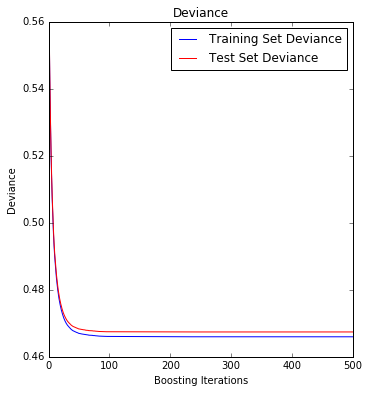

In [235]:
# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(Y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, model.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In the figure above the flat lines (after 100 iterations) show that the model is not overfitting. Thustly we can choose 100 for our # of iterators on our model.

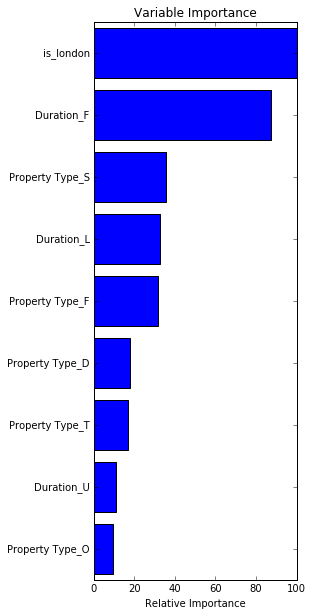

In [236]:
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [237]:
#model w/ new paramters

params = {'n_estimators': 100, 'max_depth': 2, 'min_samples_split': 2,
          'learning_rate': 0.1, 'loss': 'ls'}
model_xgb = ensemble.GradientBoostingRegressor(**params)

model_xgb.fit(X_train, Y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [238]:
xgb_preds = model_xgb.predict(X_test)
lasso_preds = model_lasso.predict(X_test)

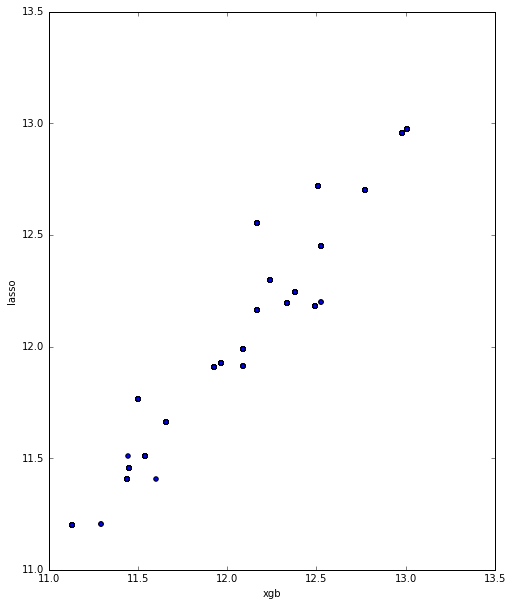

In [239]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

## Blended Regressor

The weights in the average (0.7, 0.3) are hyperparameters - I used validation set to see what the best cutoff is. Basically this means I am weighting the preds from the lasso somewhat more heavily than the xgboost preds:

In [240]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [241]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, preds)
print("MSE: %.4f" % mse)

MSE: 0.4684


# Results

Surprisingly, the Ridge regression it does really well with very little feature engineering. The key point is to to log_transform the prices since most of them are skewed. Using a simple blended regressor composed of Lasso+GBR, we were able to get and MSE of .46 on the test set.

Overall, the given features are not good predictors of price - there are large variations inside each category -- think of the range of terraced homes bought in London, the model wouldn't have granular enough data to work with. An improvement would be to take inspiration from the Boston Housing Academic dataset where they have a rich feature set to describe a house such as: square footage, proximity to work centers, quality of proximity schools, etc.